In [103]:
%load_ext autoreload
%autoreload 2

import warnings
import sys
import os
import math
warnings.filterwarnings('ignore')
 
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt 
import pprint

from scipy.stats import linregress

import tkinter as tk    # from tkinter import Tk for Python 3.x
from tkinter.filedialog import askopenfilename

import ipywidgets
from ipywidgets import interact, interactive, interact_manual, fixed
from IPython.display import clear_output
import IPython
import pylab
pylab.rcParams['figure.figsize'] = (16, 8)
width, height = pylab.rcParams['figure.figsize']

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

font = {'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[Info] Open: test_06cf.csv test_06vicon.csv


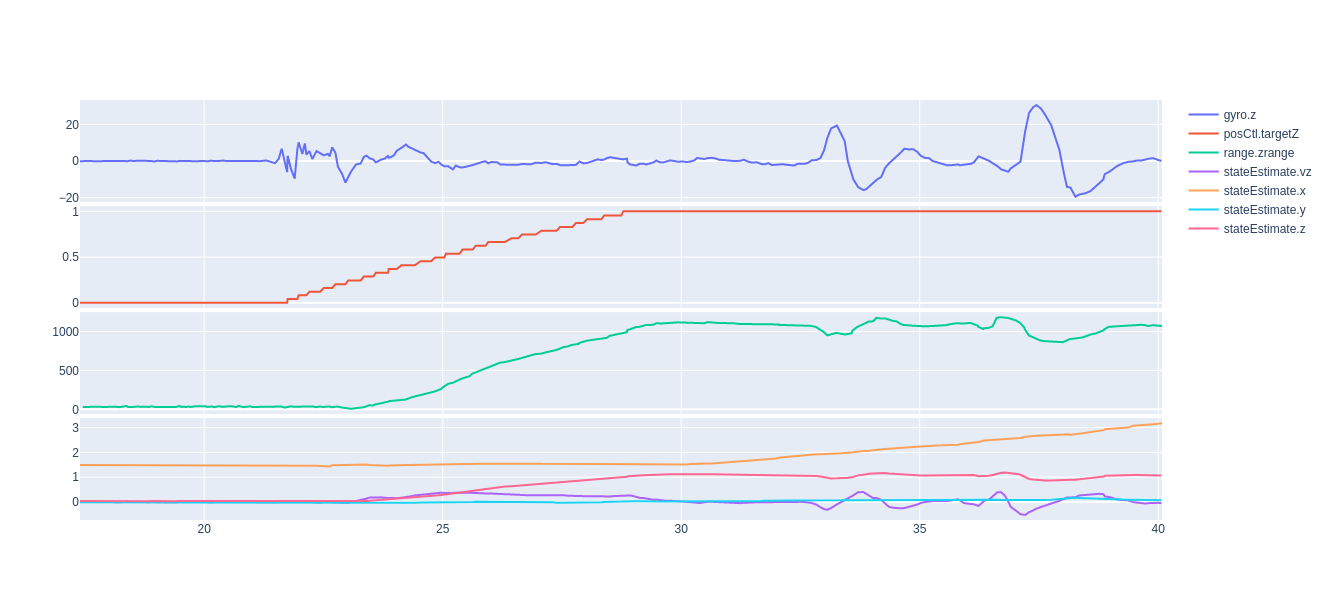

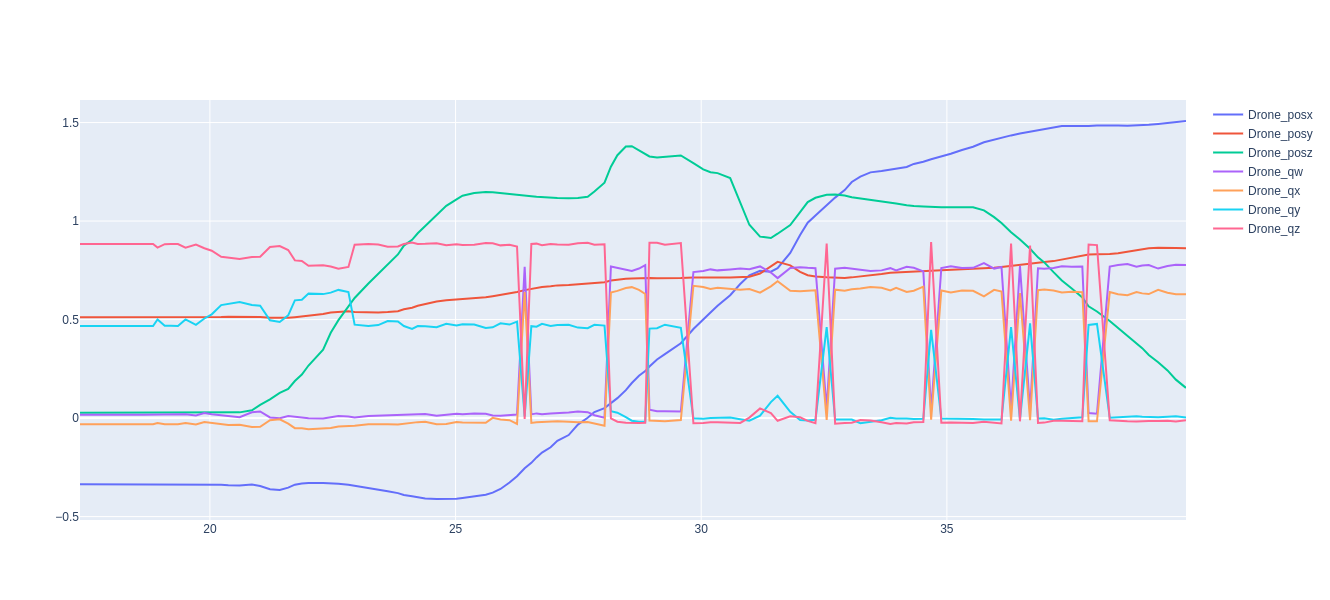

In [104]:
path_cf    = os.path.join("logs", "test_06cf.csv")
path_vicon = os.path.join("logs", "test_06vicon.csv")
print("[Info] Open:", os.path.basename(path_cf), os.path.basename(path_vicon))

import pandas as pd

CF_df = pd.read_csv(path_cf, header=0, names=["Timestamp", "ID", "Value"])

keys = []
for key in np.unique(CF_df["ID"]):
    keys.append(key.split(".")[0])
keys = np.unique(keys)

n_groups = len(keys)
fig = make_subplots(rows=n_groups, cols=1, shared_xaxes=True,vertical_spacing=0.01)

for k, group in CF_df.groupby(["ID"]):
    key = group.iloc[0,1].split(".")[0]
    group_index = np.where(keys == key)[0][0]
    fig.append_trace(go.Scatter(x=group['Timestamp']/1000, y= group['Value'], mode='lines', name="{}".format(group.iloc[0,1])), row=group_index+1, col=1)

fig.update_layout(width=15*60, height=5*120)
fig.show()

CF_df = pd.read_csv(path_vicon, header=0, names=["Timestamp", "ID", "Value"])

keys = []
for key in np.unique(CF_df["ID"]):
    t = key.split("_")[0]
    if t != "Box": 
        keys.append(t)
        
keys = np.unique(keys)

n_groups = len(keys)
fig = make_subplots(rows=n_groups, cols=1, shared_xaxes=True,vertical_spacing=0.01)

for k, group in CF_df.groupby(["ID"]):
    key = group.iloc[0,1].split("_")[0]
    group_index = np.where(keys == key)[0]
    if group_index >= 0:
        fig.append_trace(go.Scatter(x=group['Timestamp']/1000, y= group['Value'], mode='lines', name="{}".format(group.iloc[0,1])), row=int(group_index)+1, col=1)

fig.update_layout(width=15*60, height=5*120)
fig.show()

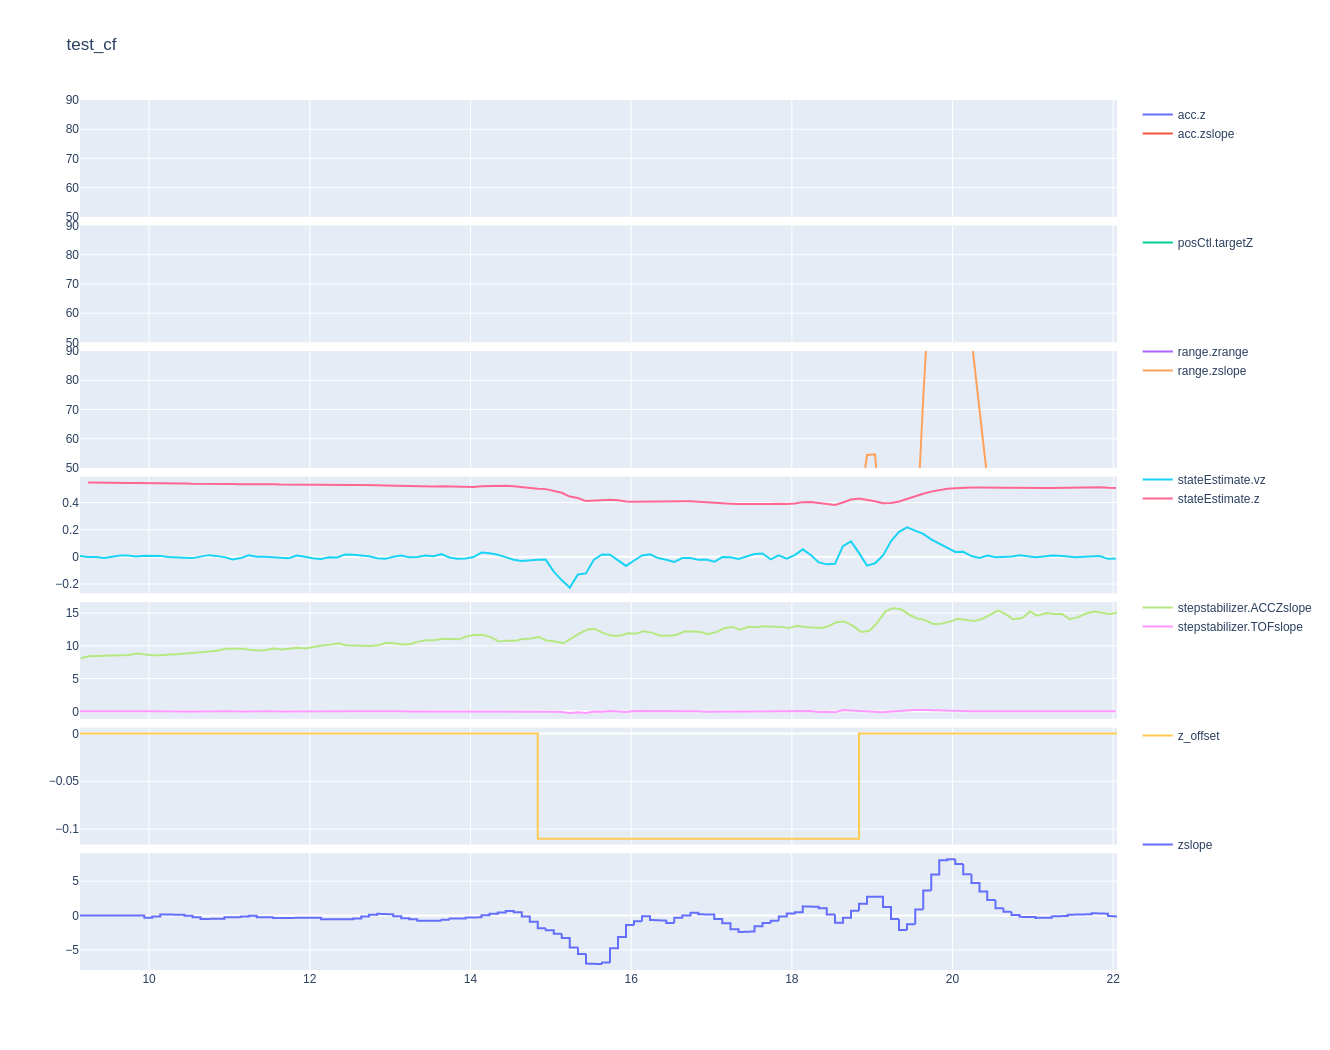

In [107]:
FILE = "offline_python_01_cf"

# read the CSV file
CF_df = pd.read_csv(os.path.join("logs", FILE +".csv"), header=0, names=["Timestamp", "Timestamp_CF", "ID", "Value"])

groups = np.unique([x.split(".")[0] for x in np.unique(CF_df["ID"])]) 

fig = make_subplots(rows=len(groups), cols=1, shared_xaxes=True, vertical_spacing=0.01)

# extract the time-of-flight sensor value
for k, group in CF_df.groupby(["ID"]):
    index = groups.tolist().index(k.split(".")[0]) + 1
    group = group.reset_index()
    fig.append_trace(go.Scatter(x=group["Timestamp"]/1000, y= group["Value"], mode="lines", name=k, legendgroup = index), row = index, col = 1)              
    
fig.update_layout(
    title_text=FILE, 
    height=len(groups)*150, 
    width=15*80, 
    legend_tracegroupgap = 90,
    yaxis1_range=[50, 90],
    yaxis2_range=[50, 90],
    yaxis3_range=[50, 90]
)
    
fig.show()

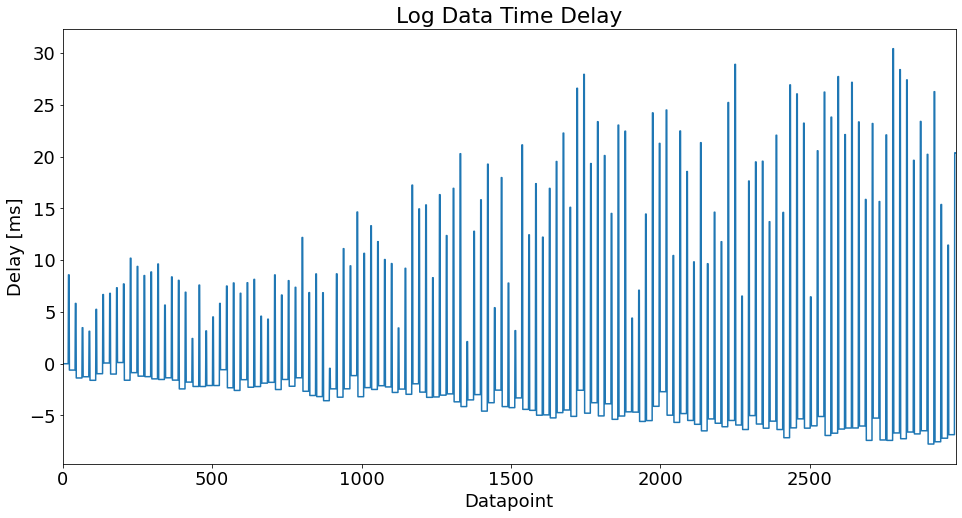

In [106]:
# Plot timestamp difference
plt.plot((CF_df["Timestamp"]-CF_df["Timestamp_CF"])-(CF_df["Timestamp"].iloc[0]-CF_df["Timestamp_CF"].iloc[0]))
plt.title("Log Data Time Delay")
plt.xlabel("Datapoint")
plt.ylabel("Delay [ms]")
plt.xlim([0, len(CF_df["Timestamp"])])
plt.show()